# Chapter 5. Model Comparison

In [116]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap, lax
from jax import nn as jnn

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [99]:
# import pymc3 as pm
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import arviz as az

In [100]:
# az.style.use('arviz-darkgrid')

Text(0, 0.5, 'y')

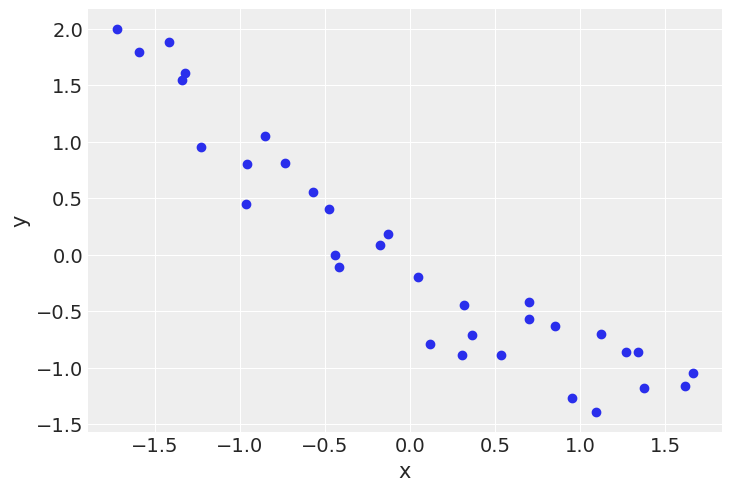

In [101]:
dummy_data = pd.read_csv('../data/dummy.csv', delimiter=' ', header=None, dtype=float)
x_1 = jnp.asarray(dummy_data)[:, 0]
y_1 = jnp.asarray(dummy_data)[:, 1]

order = 2
x_1p = jnp.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [102]:
def model_l(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=1))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfNormal(scale=5))

    μ = α + β * x_1s[0]

    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
    
kernel = NUTS(model_l)
mcmc_l = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc_l.run(random.PRNGKey(seed), obs=y_1s) 

def model_p(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=1))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=10), sample_shape=(order,))
    ϵ = numpyro.sample('ϵ', dist.HalfNormal(scale=5))

    μ = α + jnp.dot(β, x_1s)

    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
    
kernel = NUTS(model_p)
mcmc_p = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc_p.run(random.PRNGKey(seed), obs=y_1s) 

sample: 100%|█████████████████████████| 2500/2500 [00:00<00:00, 6335.13it/s, 15 steps of size 2.86e-01. acc. prob=0.94]


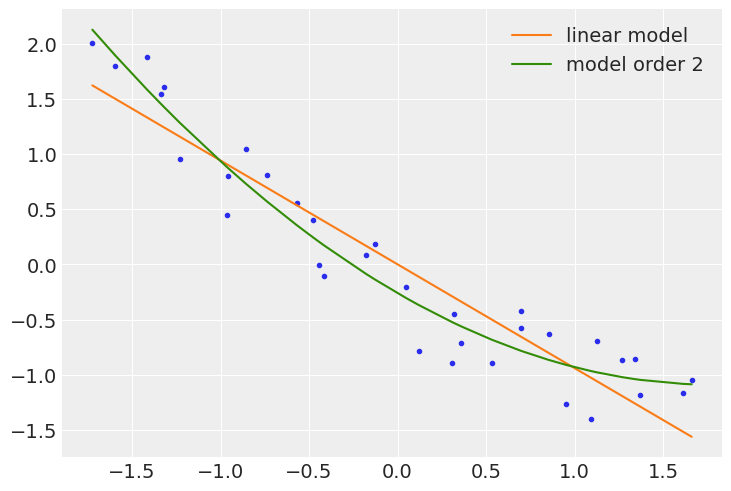

In [103]:
x_new = jnp.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = mcmc_l.get_samples()['α'].mean()
β_l_post = mcmc_l.get_samples()['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = mcmc_p.get_samples()['α'].mean()
β_p_post = mcmc_p.get_samples()['β'].mean(axis=0)
idx = jnp.argsort(x_1s[0])
y_p_post = α_p_post + jnp.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

#α_p_post = trace_p['α'].mean()
#β_p_post = trace_p['β'].mean(axis=0)
#x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
#y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

## Posterior predictive checks

<AxesSubplot:xlabel='y_pred'>

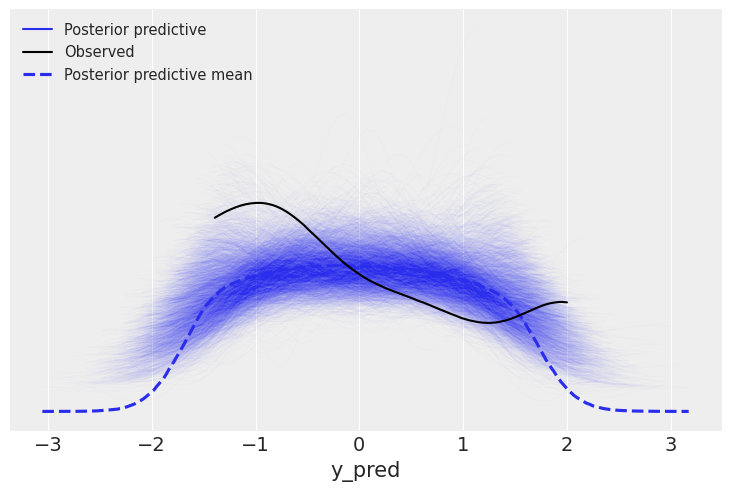

In [104]:
prior = Predictive(mcmc_l.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=y_1s)

pred = Predictive(model=mcmc_l.sampler.model, posterior_samples=mcmc_l.get_samples(), return_sites=['y_pred'])
post_p = pred(random.PRNGKey(seed))
y_l = post_p['y_pred']

samples = az.from_numpyro(mcmc_l, posterior_predictive=post_p)
az.plot_ppc(samples, mean=True, observed=True, color='C0', alpha=0.01)

<AxesSubplot:xlabel='y_pred'>

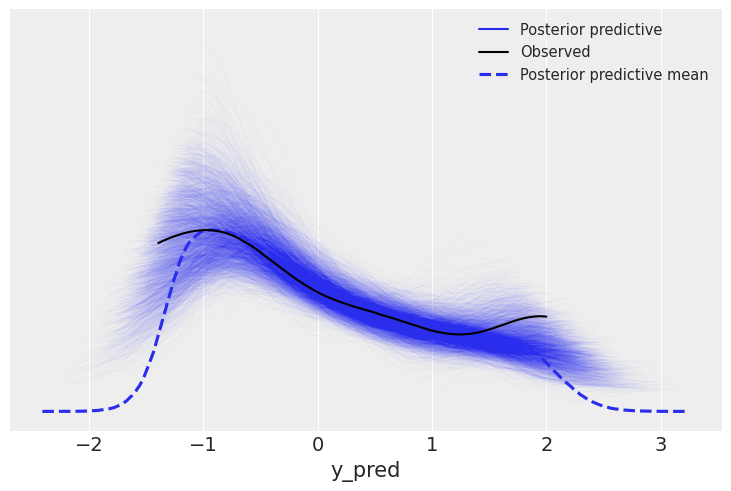

In [105]:
prior = Predictive(mcmc_p.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=y_1s)

pred = Predictive(model=mcmc_p.sampler.model, posterior_samples=mcmc_p.get_samples(), return_sites=['y_pred'])
post_p = pred(random.PRNGKey(seed))
y_p = post_p['y_pred']

samples = az.from_numpyro(mcmc_p, posterior_predictive=post_p)
az.plot_ppc(samples, mean=True, observed=True, color='C0', alpha=0.01)

([], [])

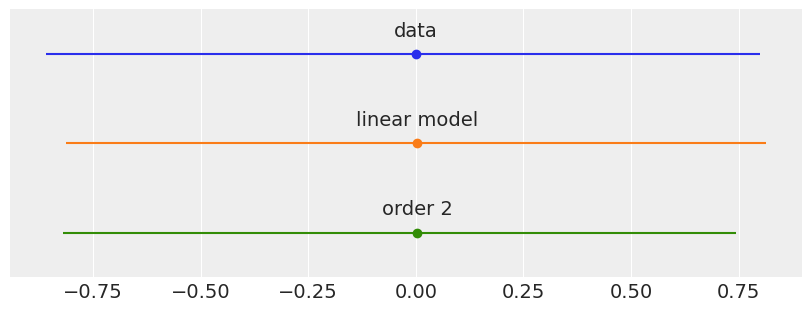

In [106]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = jnp.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

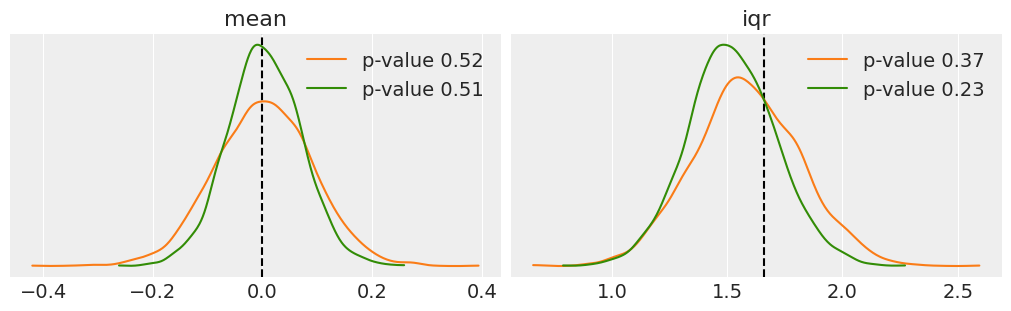

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)


def iqr(x, a=0):
    return jnp.subtract(*jnp.percentile(x, [75, 25], axis=a))


for idx, func in enumerate([jnp.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = jnp.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c}, label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

# Occam's razor – simplicity and accuracy 

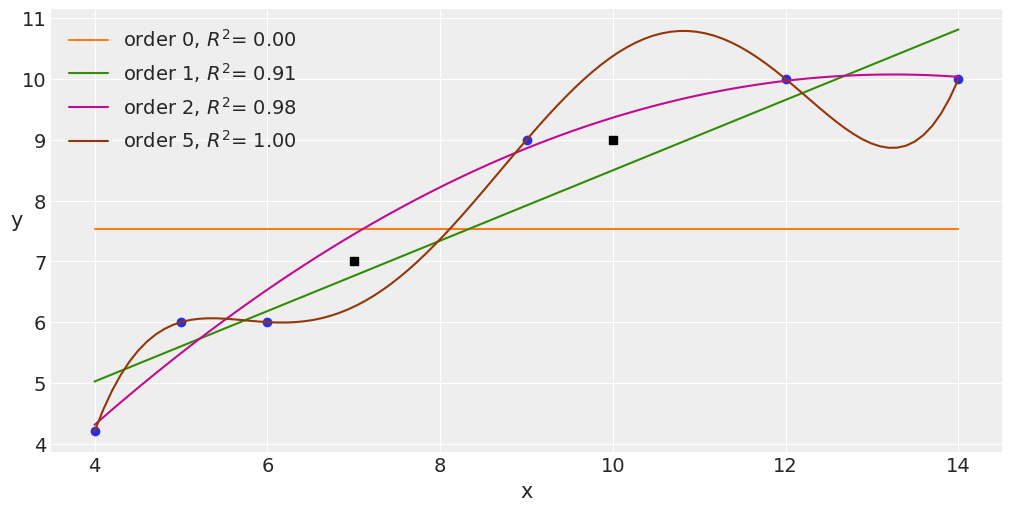

In [108]:
x = jnp.array([4., 5., 6., 9., 12, 14.])
y = jnp.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(10, 5))
orders = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in orders:
    x_n = jnp.linspace(x.min(), x.max(), 100)
    coeffs = jnp.polyfit(x, y, deg=i)
    ffit = jnp.polyval(coeffs, x_n)

#     p = onp.poly1d(coeffs)
    yhat = jnp.polyval(coeffs, x)
#     yhat = p(x)
    ybar = jnp.mean(y)
    ssreg = jnp.sum((yhat-ybar)**2)
    sstot = jnp.sum((y - ybar)**2)
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
# plt.savefig('B11197_05_05.png', dpi=300)
plt.plot([10, 7], [9, 7], 'ks')
# plt.savefig('B11197_05_06.png', dpi=300)

## Computing information criteria with PyMC3

In [109]:
waic_l = az.waic(mcmc_l)
waic_l

Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.38     2.67
p_waic        2.44        -

In [110]:
cmp_df = az.compare({'model_l':mcmc_l, 'model_p':mcmc_p},
                    method='BB-pseudo-BMA')
cmp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.579088,2.623271,0.000000,0.99838,2.573341,0.000000,False,log
model_l,1,-14.409419,2.472847,9.830331,0.00162,2.285021,2.655246,False,log


<AxesSubplot:xlabel='Log'>

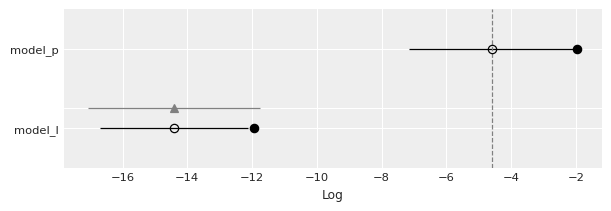

In [111]:
az.plot_compare(cmp_df)

## Model Averaging

In [13]:
# TODO: figure out how to do this in numpyro
# w = 0.5
# y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p],
#                                         samples=1000,
#                                         models=[model_l, model_p],
#                                         weights=[w, 1-w])

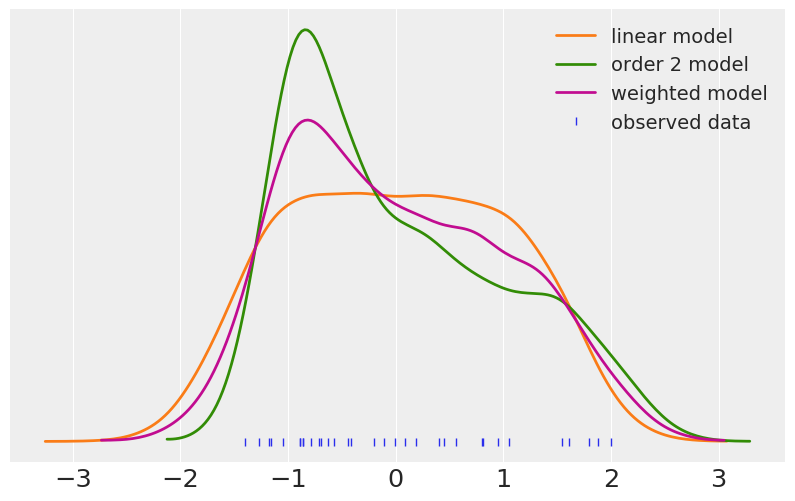

In [14]:
# _, ax = plt.subplots(figsize=(10, 6))
# az.plot_kde(y_l, plot_kwargs={'color': 'C1'}, label='linear model', ax=ax)
# az.plot_kde(y_p, plot_kwargs={'color': 'C2'}, label='order 2 model', ax=ax)
# az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
#            label='weighted model', ax=ax)

# plt.plot(y_1s, jnp.zeros_like(y_1s), '|', label='observed data')
# plt.yticks([])
# plt.legend()
# plt.savefig('B11197_05_09.png', dpi=300)

# Bayes factors

In [114]:
coins = 30 # 300
heads = 9 # 90
y_d = jnp.repeat(jnp.array([0, 1]), jnp.array([coins-heads, heads]))

In [156]:
# !pip install pymc3
# import pymc3 as pm

     |████████████████████████████████| 869 kB 195 kB/s eta 0:00:01
     |████████████████████████████████| 86 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 537 kB/s eta 0:00:01     |█████████████████████████▍      | 1.4 MB 172 kB/s eta 0:00:03
     |████████████████████████████████| 233 kB 1.2 MB/s eta 0:00:01
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=c278453d9c58916b0c105fe7db00b2896be93d0a917c5275f054ed318332e54a
  Stored in directory: /Users/tallamjr/Library/Caches/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [159]:
pm.math.eq(model_index, 0)

Elemwise{eq,no_inplace}.0

In [158]:
m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
m

Elemwise{switch,no_inplace}.0

In [167]:
p = jnp.array([0.5, 0.5])
print(p)
model_index = dist.Categorical(probs=p).sample(key=random.PRNGKey(2), sample_shape=(10,))

m_0 = (4, 8)
m_1 = (8, 4)
checkeq = lax.eq(model_index, 0)
checkeq.astype(int)
print(checkeq.astype(int))
# m = lax.switch(checkeq, m_0, m_1)
# m = lax.switch(checkeq, m_0, m_1)

[0.5 0.5]
[1 0 0 1 1 1 1 0 0 1]


In [160]:
# def model(obs=None):
#     p = jnp.array([0.5, 0.5])
#     model_index = numpyro.sample('model_index', dist.Categorical(probs=p))

#     m_0 = (4, 8)
#     m_1 = (8, 4)
#     checkeq = lax.eq(model_index, 0).astype(int)
#     m = lax.switch(checkeq, m_0, m_1)
# #     m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

#     # a priori
#     θ = numpyro.sample('θ', dist.Beta(concentration1=m[0], concentration0=m[1]))
#     # likelihood
#     y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)
    
    
# kernel = NUTS(model)
# mcmc_BF = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
# mcmc_BF.run(random.PRNGKey(seed), obs=y_d) 

# az.plot_trace(mcmc_BF)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


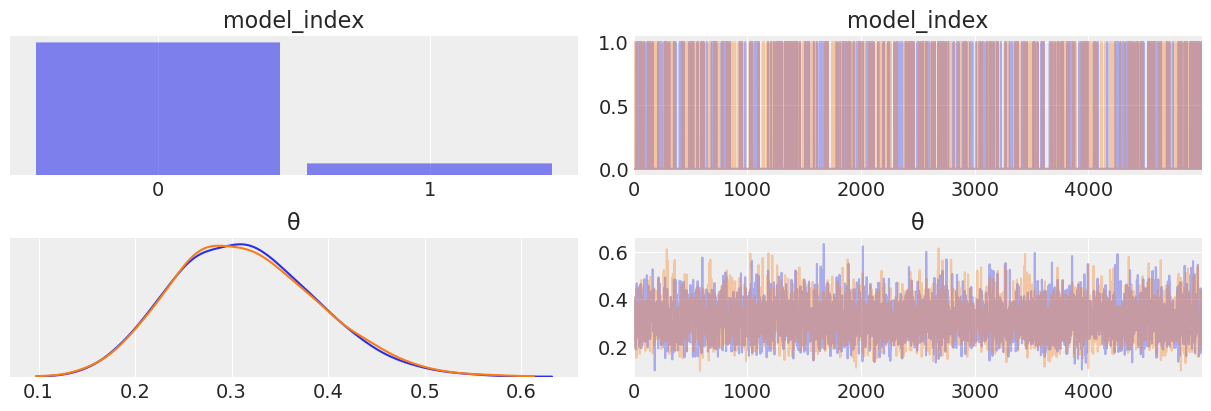

In [16]:
# with pm.Model() as model_BF:
#     p = np.array([0.5, 0.5])
#     model_index = pm.Categorical('model_index', p=p)

#     m_0 = (4, 8)
#     m_1 = (8, 4)
#     m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

#     # a priori
#     θ = pm.Beta('θ', m[0], m[1])
#     # likelihood
#     y = pm.Bernoulli('y', θ, observed=y_d)

#     trace_BF = pm.sample(5000)
# az.plot_trace(trace_BF)
# plt.savefig('B11197_05_11.png', dpi=300)

In [169]:
# pM1 = mcmc_BF.get_samples()['model_index'].mean()
# pM0 = 1 - pM1
# BF = (pM0 / pM1) * (p[1] / p[0])
# BF

In [18]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample(2500, step=pm.SMC())

with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample(2500, step=pm.SMC())

Sample initial stage: ...
Stage: 0 Beta: 1.000 Steps: 25
Sample initial stage: ...
Stage: 0 Beta: 0.208 Steps: 25
Stage: 1 Beta: 0.702 Steps: 4
Stage: 2 Beta: 1.000 Steps: 3


In [19]:
model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

10.959882779855683

## Bayes factors and information criteria

In [20]:
traces = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            trace = pm.sample(2000)
            traces.append(trace)
            waics.append(az.waic(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


The acceptance probability does not match the target. It is 0.8885416183572553, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990260264000074, but should be close to 0.8. Try to increase the number of tuning steps.


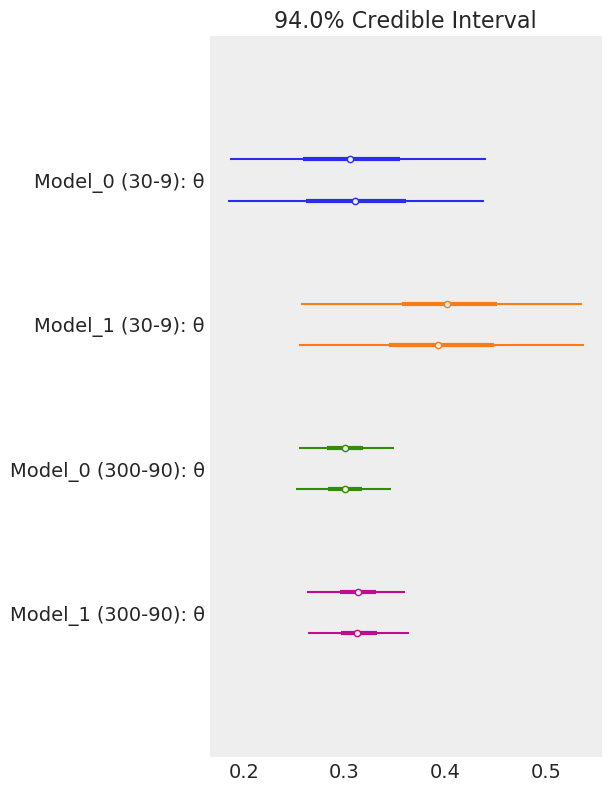

In [21]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

az.plot_forest(traces, model_names=model_names)
plt.savefig('B11197_05_12.png', dpi=300)

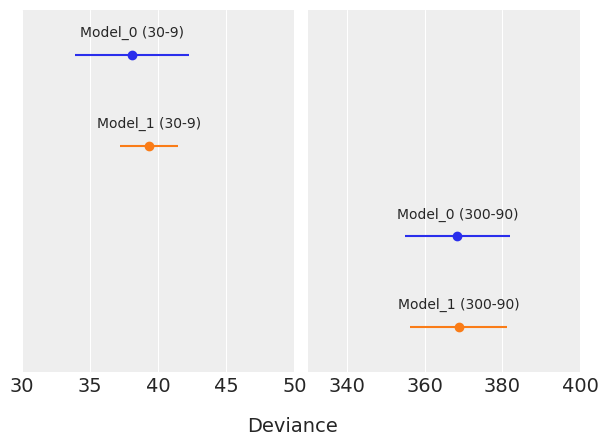

In [22]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')

ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14)
plt.savefig('B11197_05_13.png', dpi=300)

## Regularizing priors

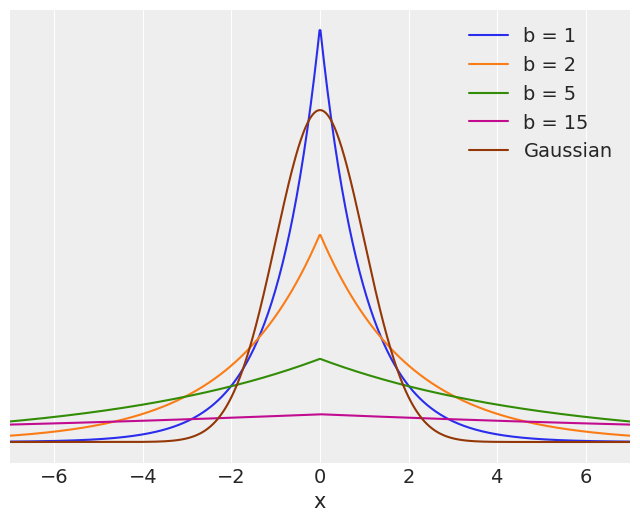

In [23]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 1000)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f'b = {df}')

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-7, 7)
plt.savefig('B11197_05_14.png', dpi=300)

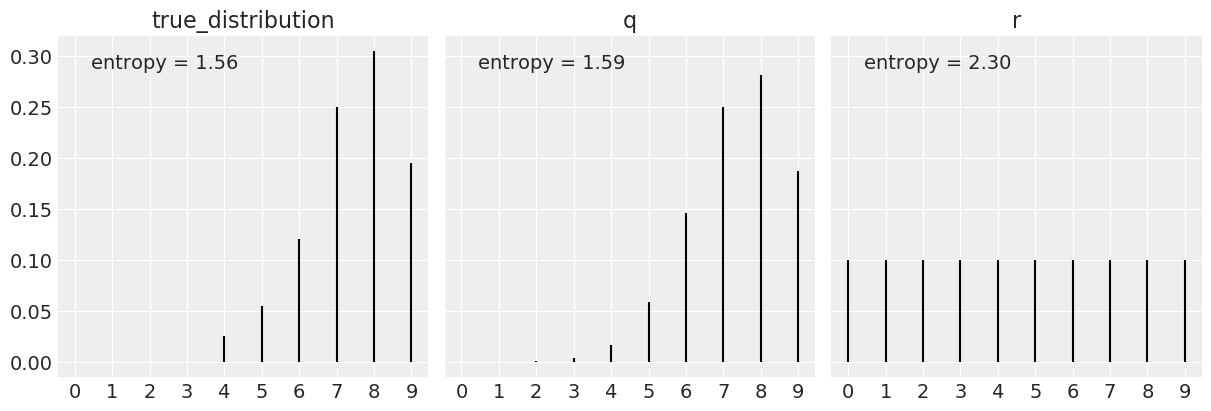

In [24]:
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)

true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]

q_pmf = q.pmf(x)
r_pmf = r.pmf(x)

_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,
                     constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

plt.savefig('B11197_05_15.png', dpi=300)

In [25]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution, r_pmf)

(0.009657896086383405, 0.7394593875511319)

In [26]:
stats.entropy(r_pmf, q_pmf), stats.entropy(q_pmf, r_pmf)

(2.756929658156367, 0.7154903060638594)